In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import HTML, clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game, get_valid_actions

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X
from agent_code.tensor_agent.model import FullModel, Counter

choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
action_y_map = {choices[i]: i for i in range(len(choices))}
D = len(choices)

clear_output()

In [2]:
hp.buffer_size = 100000
hp.target_network_period = 10000
hp.epsilon = 0.
hp.learning_rate=0.001
hp.discount_factor=0.99
hp.peaceful = False

aux_rewards = {
    e.WAITED: -0.1,
    e.CRATE_DESTROYED: 0.2,
    e.COIN_COLLECTED: 0,
    e.KILLED_OPPONENT: 0,
    e.KILLED_SELF: 0,
    e.GOT_KILLED: 0
}

hurry_up = 1 * (1 - hp.discount_factor)

In [3]:
class HallOfFame:
    def __init__(self):
        self.weights = []
    
    def add(self, weights):
        self.weights.append(weights)
        if len(self.weights) > 50:
            self.weights = self.weights[::2]

HoF = HallOfFame()

In [4]:


K.clear_session()
#model = FullModel(game_state_X.shape, D)

def make_agent():
    return TensorAgent(game_state_X.shape, D, weights='crate_survivor400k.h5', model=FullModel(game_state_X.shape, D))

tensor_agent = make_agent()

original = 'tensor_agent'
copies = [f'tensor_agent-copy{i}' for i in range(3)]
additional = [f'tensor_agent{i}' for i in range(3)]

agents = {
    original: tensor_agent
}

for n in copies:
    agents[n] = tensor_agent.clone()

for n in additional:
    agents[n] = make_agent()


train = {a: False for a in agents}
clear_output()

In [5]:
#model.target.summary()

In [6]:
class AgentInfo(object):
    def __init__(self, agents, moving_rewards):
        self.agents = agents
        self.moving_rewards = moving_rewards

    def _repr_pretty_(self, pp, cycle):
        text = ''
        for n, a in self.agents.items():
            text +=  '=====================\n'
            text += f'{n} ({a.model.family}) \n'
            text += f'trained: {a.model.steps} \n'
            text += f'moving reward: {moving_rewards[n]:.2f} \n'
        pp.text(text)
        
    def __repr__(self):
        return str(self.agents.keys().join(','))

In [8]:

total_step = 0

In [9]:
d = display(f'Starting...', display_id='progress')


n_steps = 2000000
game = None
current_agents = {}

train = {n: False for n in agents.keys()}
for n in [original] + copies:
    train[n] = True
#train['tensor_agent'] = True

moving_rewards = {n: 0 for n in agents.keys()}
episode_count = 0

info = AgentInfo(agents, moving_rewards)
agent_display = display(info, display_id='agent_info')



for step in range(total_step, n_steps):
    if game is None:
        episode_count += 1
        
        #=== Choose Agents ===
        if len(HoF.weights) > 2 and np.random.rand() < 0.2:
            current_agents = {n: agents[n] for n in [original] + additional}
            for n in additional:
                agents[n].model.set_weights(HoF.weights[np.random.choice(len(HoF.weights))])
        else:
            current_agents = {n: agents[n] for n in [original] + copies}
        
        
        #=== Choose Game ===
        choice = np.random.choice(['coins', 'full'], p=[0.1,0.9])
        if choice == 'coins':
            game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.))
        else: # 'full'
            game = Game(*Game.create_arena(current_agents.keys(),\
                                           crate_density=np.random.uniform(low=0.5, high=1.0)))
        dead_rewards = {}

    total_step += 1
    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards, events = game.step(actions_as_string)
    
    ex_rewards = {}
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
        ex_rewards[name] = rewards[name] + np.sum([events[name][event] * aux_rewards[event] for event in aux_rewards.keys()])
    
    #=== Delayed reward on death ===
    for name in actions.keys():
        if events[name][e.GOT_KILLED]:
            dead_rewards[name] = [ex_rewards[name], np.maximum(len(game.agents)-1, 1), Xs[name], actions[name]]
    
    for _,_,name,_,_ in game.agents:
        for dr in dead_rewards.values():
            dr[0] -= rewards[name]
    #===============================
    
    for _,_,name,_,_ in game.agents:
        reward = ex_rewards[name]
        for _,_,opponent,_,_ in game.agents:
            if opponent != name:
                reward -= rewards[opponent] / (len(game.agents) - 1)
        if train[name]:
            current_agents[name].reward_update([Xs[name], actions[name], reward])
            
    
    agent_display.update(info)
    
    if step % 100000 == 0:
        tensor_agent.model.save(f'tensor_agent-model{total_step}.h5')
    
    if game.terminated:
        # Apply delayed reward for death
        for name, dr in dead_rewards.items():
            if train[name]:
                current_agents[name].reward_update([dr[2], dr[3], dr[0]/dr[1]])
        
        for name, a in current_agents.items():
            a.end_of_episode() # alt: save=None
        
        if episode_count % 100 == 0:
            HoF.add(tensor_agent.model.get_weights())
        
        d.update(f'Episode {episode_count} Step: {step+1}/{n_steps}')
        game = None

d.update(f'Complete')

'Episode 5115 Step: 301102/2000000'

tensor_agent (adoring_crate_advocate) 
trained: 101807 
moving reward: 1.26 
tensor_agent-copy0 (adoring_crate_advocate) 
trained: 101807 
moving reward: 2.60 
tensor_agent-copy1 (adoring_crate_advocate) 
trained: 101807 
moving reward: 3.31 
tensor_agent-copy2 (adoring_crate_advocate) 
trained: 101807 
moving reward: 1.38 
tensor_agent0 (bold_bomb_lover) 
trained: 0 
moving reward: 3.15 
tensor_agent1 (confident_crate_researcher) 
trained: 0 
moving reward: 4.16 
tensor_agent2 (stoic_crate_advocate) 
trained: 0 
moving reward: 3.61 


KeyboardInterrupt: 

In [17]:
train

{'tensor_agent': True,
 'tensor_agent-copy0': True,
 'tensor_agent-copy1': True,
 'tensor_agent-copy2': True}

In [ ]:
for n, a in agents.items():
    a.model.save(f'{n}-model.h5')

In [14]:
d = display(f'Starting...', display_id='progress_test')

n_steps = 1000
game = None

current_agents = {n: agents[n] for n in [original] + copies}
train = {n: False for n in agents.keys()}
moving_rewards = {n: 0 for n in current_agents.keys()}

info = AgentInfo(current_agents, moving_rewards)
agent_display = display(info, display_id='agent_info_test')

imgs = []

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(current_agents.keys(), crate_density=0.75))

    actions = {}
    Xs = {}
    img = np.zeros((17, 17, 3))
    
    for agent in game.agents:
        x, y, name, b, _ = agent
        
        game_state = game.get_game_state(agent)
        img[:,:,0] = (game_state['arena'] == -1) * 0.75
        img[:,:,0] += game_state['arena'] == 1
        coins = game_state['coins']
        for i in range(len(coins)):
            img[coins[i][0], coins[i][1], 1] = 0.75
        img[x,y,1] = 1
        img[:,:,2] = game_state['explosions'] / np.max(game_state['explosions'])
        bombs = game_state['bombs']
        
        for i in range(len(bombs)):
            img[bombs[i][0], bombs[i][1], 2] = 0.75 - bombs[i][2] / (s.bomb_timer) / 2
        
        Xs[name] = game_state_X.get(game_state)
        valid_actions = get_valid_actions(x, y, b, game)
        actions[name] = current_agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    imgs.append(img)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    print(actions_as_string)
    rewards, events = game.step(actions_as_string)
    
    for name in actions.keys():
        moving_rewards[name] = 0.99 * moving_rewards[name] + rewards[name]
    
    d.update(f'Step: {step+1}/{n_steps}')
    agent_display.update(info)
    
    if game.terminated:
        #for name, a in agents.items():
            #a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        break


'Step: 380/1000'

tensor_agent (adoring_crate_advocate) 
trained: 101807 
moving reward: 0.94 
tensor_agent-copy0 (adoring_crate_advocate) 
trained: 101807 
moving reward: 1.51 
tensor_agent-copy1 (adoring_crate_advocate) 
trained: 101807 
moving reward: 0.40 
tensor_agent-copy2 (adoring_crate_advocate) 
trained: 101807 
moving reward: 1.56 


{'tensor_agent': 'LEFT', 'tensor_agent-copy0': 'LEFT', 'tensor_agent-copy1': 'UP', 'tensor_agent-copy2': 'DOWN'}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


{'tensor_agent': 'BOMB', 'tensor_agent-copy0': 'BOMB', 'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'BOMB'}
{'tensor_agent': 'RIGHT', 'tensor_agent-copy0': 'RIGHT', 'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'UP'}
{'tensor_agent': 'UP', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'RIGHT'}
{'tensor_agent': 'DOWN', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent': 'UP', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'RIGHT'}
{'tensor_agent': 'WAIT', 'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'WAIT', 'tensor_agent-copy2': 'WAIT'}
{'tensor_agent': 'BOMB', 'tensor_agent-copy0': 'BOMB', 'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'BOMB'}
{'tensor_agent': 'DOWN', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent': 'LEFT', 'tensor_agent-copy0': 'UP', 'tensor_agent-copy1': 'UP', 'te

{'tensor_agent-copy0': 'LEFT', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'BOMB'}
{'tensor_agent-copy0': 'RIGHT', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent-copy0': 'LEFT', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'RIGHT', 'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'UP'}
{'tensor_agent-copy0': 'RIGHT', 'tensor_agent-copy1': 'LEFT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'DOWN', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'BOMB'}
{'tensor_agent-copy0': 'DOWN', 'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'LEFT'}
{'tensor_agent-copy1': 'BOMB', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT', 'tensor_agent-copy2'

{'tensor_agent-copy1': 'BOMB'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'BOMB'}
{'tensor_agent-copy1': 'LEFT'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'BOMB'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'LEFT'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'BOMB'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1': 'DOWN'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'BOMB'}
{'tensor_agent-copy1': 'RIGHT'}
{'tensor_agent-copy1': 'UP'}
{'tensor_agent-copy1

In [11]:

def animation(imgs, interval=50):
    import matplotlib.animation
    
    steps = len(imgs)
    
    fig = plt.gcf()
    plt.axis('off')

    def animate(t):
        plt.imshow(imgs[t])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=steps, interval=interval)
    return ani

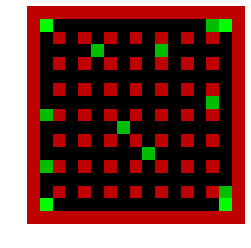

In [13]:
anim = animation(imgs[:40], interval=300)
HTML(anim.to_jshtml())

In [15]:
from PIL import Image
! rm anim/*
for i in range(len(imgs)):
    Image.fromarray(np.uint8(imgs[i]*255)).resize((17*10,17*10)).save('anim/{:0>3d}.png'.format(i))

In [16]:
! convert anim/*.png movie.gif

/bin/sh: 1: convert: not found
